# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

import tensorflow as tf

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow import keras

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.models import load_model

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Displaying Images

In [3]:
picture_size = 48
folder_path = "./dataset/"

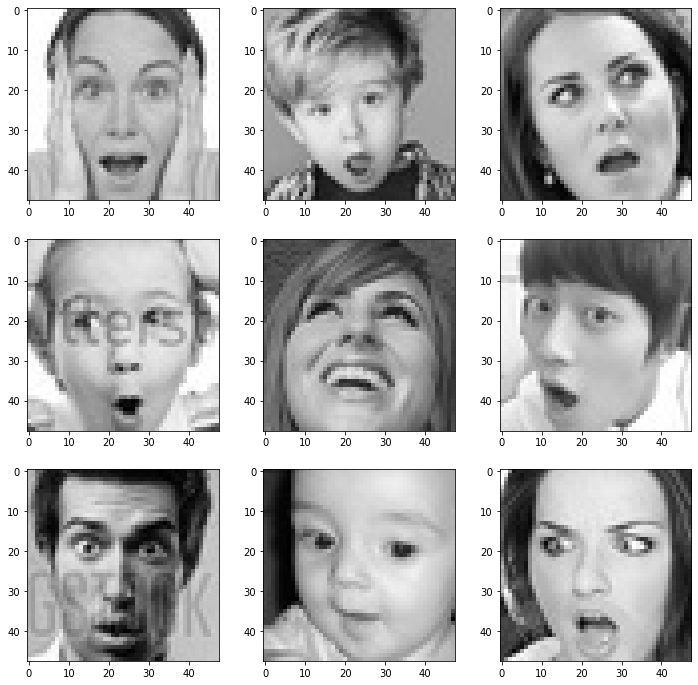

In [4]:
expression = 'surprise'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

# Making Training and Validation Data

In [5]:
batch_size  = 64

datagen_train  = ImageDataGenerator(rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))

# datagen_train  = ImageDataGenerator()

datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Model Building

In [6]:
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

def cnn2():
    no_of_classes = 7

    model = Sequential()

    #1st CNN layer
    model.add(Conv2D(96,(3,3),padding = 'same',input_shape = (48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

    #2nd CNN layer
    model.add(Conv2D(96,(5,5),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.25))

    #3rd CNN layer
    model.add(Conv2D(96,(5,5),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.5))

    #4th CNN layer
    model.add(Conv2D(192,(7,7), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    #Fully connected 1st layer
    model.add(Dense(192))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    # Fully connected layer 2nd layer
    model.add(Dense(192))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(no_of_classes, activation='softmax'))



    opt = Adam(learning_rate = 0.0001)
    model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [7]:
model= cnn2()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 96)        960       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 96)        2

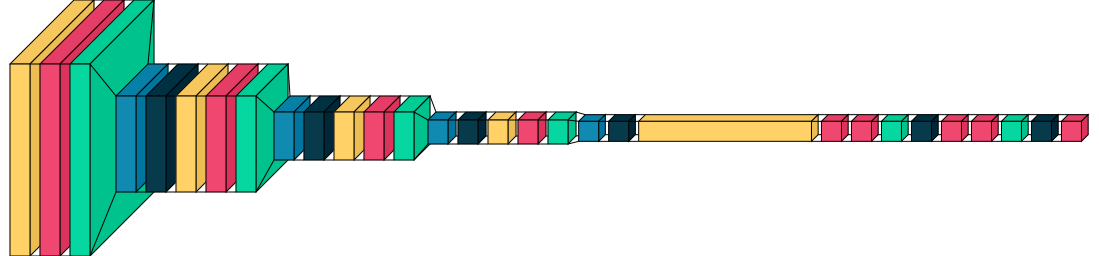

In [8]:
import visualkeras
visualkeras.layered_view(model)

# Fitting the Model with Training and Validation Data 

In [8]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model/model2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=25,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=20,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint]

epochs = 150

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [9]:
history = model.fit(train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/150
448/448 [==============================] - ETA: 0s - loss: 2.1040 - accuracy: 0.1855
Epoch 1: val_accuracy improved from -inf to 0.25698, saving model to ./model\model2.h5
448/448 [==============================] - 64s 121ms/step - loss: 2.1040 - accuracy: 0.1855 - val_loss: 1.8231 - val_accuracy: 0.2570
Epoch 2/150
448/448 [==============================] - ETA: 0s - loss: 1.9532 - accuracy: 0.2103
Epoch 2: val_accuracy did not improve from 0.25698
448/448 [==============================] - 50s 111ms/step - loss: 1.9532 - accuracy: 0.2103 - val_loss: 1.8054 - val_accuracy: 0.2527
Epoch 3/150
448/448 [==============================] - ETA: 0s - loss: 1.8984 - accuracy: 0.2185
Epoch 3: val_accuracy did not improve from 0.25698
448/448 [==============================] - 36s 81ms/step - loss: 1.8984 - accuracy: 0.2185 - val_loss: 1.7921 - val_accuracy: 0.2527
Epoch 4/150
448/448 [==============================] - ETA: 0s - loss: 1.8790 - accuracy: 0.2209
Epoch 4: val_accuracy 

Epoch 28/150
448/448 [==============================] - ETA: 0s - loss: 1.4428 - accuracy: 0.4443
Epoch 28: val_accuracy improved from 0.51395 to 0.51744, saving model to ./model\model2.h5
448/448 [==============================] - 34s 76ms/step - loss: 1.4428 - accuracy: 0.4443 - val_loss: 1.2617 - val_accuracy: 0.5174
Epoch 29/150
448/448 [==============================] - ETA: 0s - loss: 1.4263 - accuracy: 0.4490
Epoch 29: val_accuracy improved from 0.51744 to 0.51869, saving model to ./model\model2.h5
448/448 [==============================] - 34s 76ms/step - loss: 1.4263 - accuracy: 0.4490 - val_loss: 1.2478 - val_accuracy: 0.5187
Epoch 30/150
448/448 [==============================] - ETA: 0s - loss: 1.4230 - accuracy: 0.4519
Epoch 30: val_accuracy improved from 0.51869 to 0.51911, saving model to ./model\model2.h5
448/448 [==============================] - 34s 76ms/step - loss: 1.4230 - accuracy: 0.4519 - val_loss: 1.2396 - val_accuracy: 0.5191
Epoch 31/150
448/448 [============

Epoch 55/150
448/448 [==============================] - ETA: 0s - loss: 1.2798 - accuracy: 0.5114
Epoch 55: val_accuracy improved from 0.56822 to 0.56948, saving model to ./model\model2.h5
448/448 [==============================] - 33s 74ms/step - loss: 1.2798 - accuracy: 0.5114 - val_loss: 1.1250 - val_accuracy: 0.5695
Epoch 56/150
448/448 [==============================] - ETA: 0s - loss: 1.2753 - accuracy: 0.5123
Epoch 56: val_accuracy improved from 0.56948 to 0.57631, saving model to ./model\model2.h5
448/448 [==============================] - 33s 74ms/step - loss: 1.2753 - accuracy: 0.5123 - val_loss: 1.1041 - val_accuracy: 0.5763
Epoch 57/150
448/448 [==============================] - ETA: 0s - loss: 1.2719 - accuracy: 0.5149
Epoch 57: val_accuracy did not improve from 0.57631
448/448 [==============================] - 33s 74ms/step - loss: 1.2719 - accuracy: 0.5149 - val_loss: 1.1469 - val_accuracy: 0.5586
Epoch 58/150
448/448 [==============================] - ETA: 0s - loss: 1

KeyboardInterrupt: 

In [10]:
model_json = model.to_json()
with open("./model/model2.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./model/model2.h5")
print("Saved model to disk")

Saved model to disk


# Plotting Accuracy & Loss

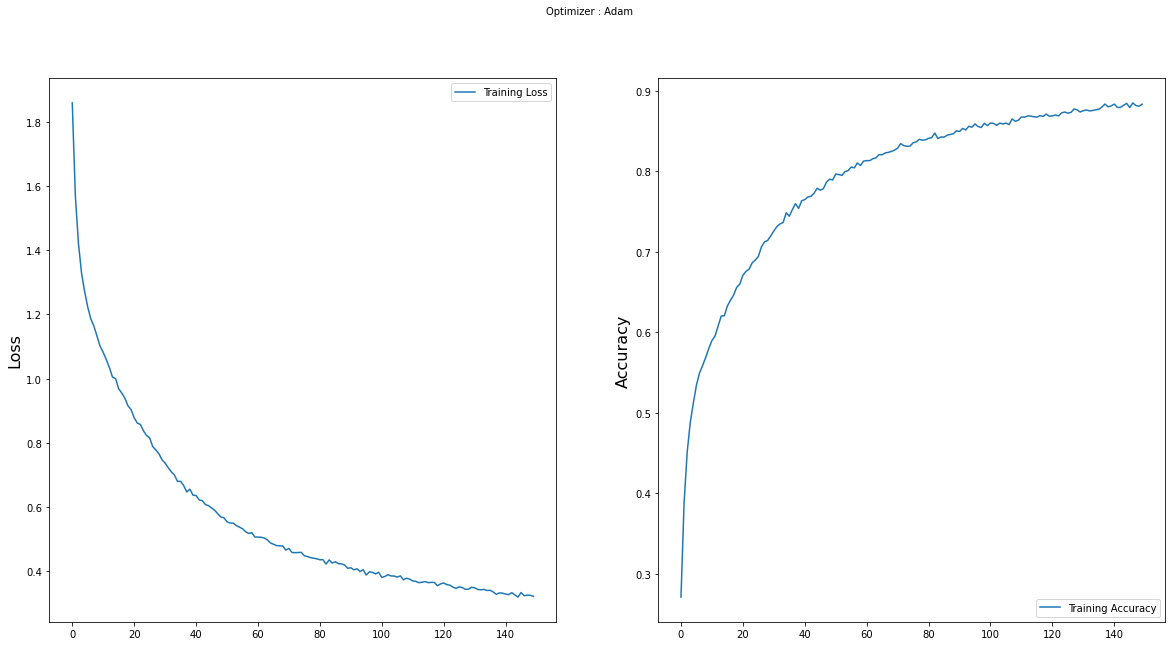

In [11]:
# plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
Y_pred = model.predict(test_set, 7178 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['angry', 'disgust', 'fear','happy','neutral','sad','surprise']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

57/57 [==============================] - 4s 60ms/step
Confusion Matrix
[[110   7  79 253 191 212 106]
 [ 11   4  12  25  26  20  13]
 [130  12  91 250 205 221 115]
 [252  32 149 418 321 395 207]
 [144  14 122 300 259 247 147]
 [147  14 120 302 232 292 140]
 [111   3  72 201 167 183  94]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.11      0.12       958
     disgust       0.05      0.04      0.04       111
        fear       0.14      0.09      0.11      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.18      0.21      0.20      1233
         sad       0.19      0.23      0.21      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.17      0.18      0.17      7178

